<a href="https://colab.research.google.com/github/peppamint/DRV8825-Module-Board/blob/main/waveform_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss

In [ ]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']


# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72

In [ ]:
def load_dir(dirname):
    fpaths = sorted(Path(dirname).glob('*.csv'))
    # Check if any CSV files were found
    if not fpaths:
        raise FileNotFoundError(f"No CSV files found in the directory: {dirname}")

    #read first file to get unit map
    df0 = pd.read_csv(fpaths[0])
    #transpose first row to dictionary
    unit_map = df0.head(1).T.to_dict()[0]
    #number of actual data rows
    N = len(df0)-1
    #number of files/snapshots
    M = len(fpaths)
    #initialize data matrices with shape (N,M)
    # A = np.empty((N,M))
    B = np.empty((N,M))
    #Pulls the Channel A column values from df into column i of A. Repeats for all files.
    for i, fpath in enumerate(fpaths):
        df = pd.read_csv(fpath, skiprows=[1]) #skip the unit row
        # A[:,i] = df['Channel A'].values
        B[:,i] = df['Channel B'].values
    #grabs the Time column from the last-loaded df to produce the shared time vector t
    t = df.Time.values
    #return t, A, B, unit_map
    return t, B, unit_map

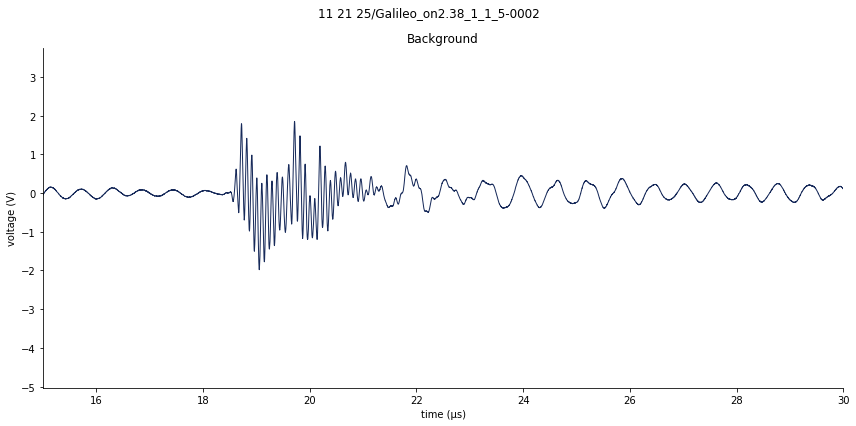

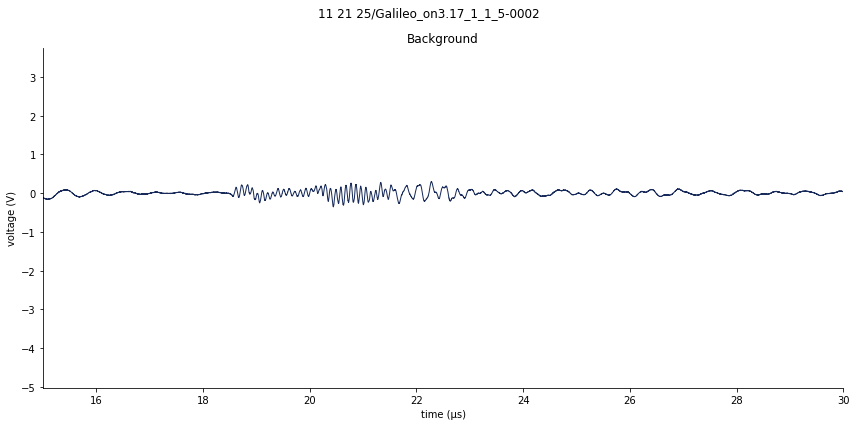

In [ ]:
def channel_b_plot(t, B, filename):
  tmin, tmax = 15, 30
  plt.figure(figsize=(12,6))
  plt.suptitle(filename)

  plt.subplot(1,1,1)
  plt.plot(t, B.mean(1), c=cp[0], lw=1)
  plt.xlim(tmin, tmax)
  plt.xlabel('time (µs)')
  plt.ylabel('voltage (V)')
  plt.title('Background')


  plt.tight_layout()
  figures_dir = Path("loaded_img")
  figures_dir.mkdir(exist_ok=True)
  # Sanitize filename to avoid creating subdirectories
  sanitized_filename = filename.replace('/', '_').replace('\\', '_')
  plt.savefig(figures_dir / f"difference_{sanitized_filename}.png", dpi=300, bbox_inches="tight")
  plt.show()

#use case:
#t, B, unit_map = load_dir('10-10-25/Galileo_onemptytube2.8_1_1_4')
t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')
channel_b_plot(t, B, '11 21 25/Galileo_on2.38_1_1_5-0002')

t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002')
channel_b_plot(t, B, '11 21 25/Galileo_on3.17_1_1_5-0002')



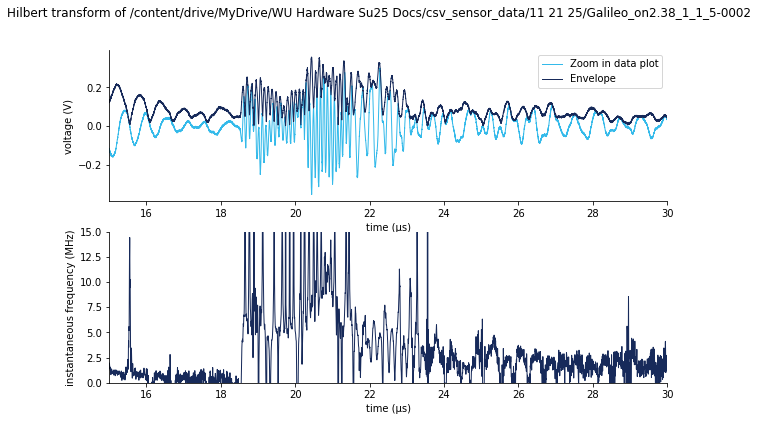

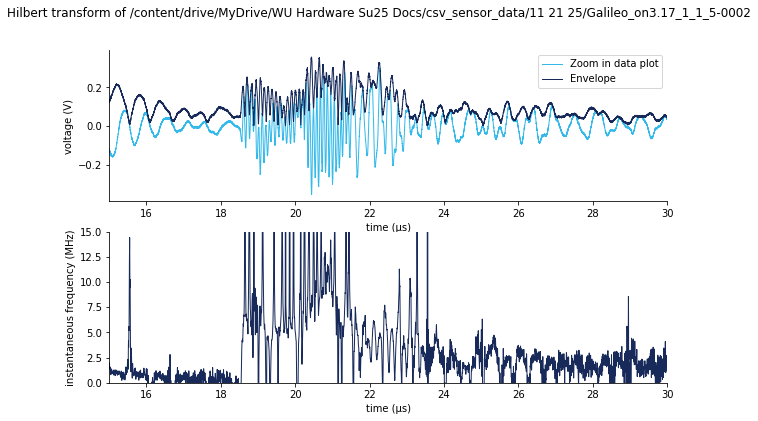

In [ ]:

#channel B Hilbert
def channel_b_hilbert(t, B, filename):

  Bmean = B.mean(1)
  ta, tb = 15, 30
  twin = (t > ta) & (t <= tb)
  Bh = ss.hilbert(Bmean)

  phi = np.unwrap(np.angle(Bh))
  window = ss.windows.hann(21)
  window /= window.sum()
  phi = ss.convolve(phi-phi.mean(), window, mode='same')
  dphidt = np.gradient(phi) / np.gradient(t)
  dphidt /= 2*np.pi

  plt.figure(figsize=(10,6))
  plt.suptitle(f'Hilbert transform of {filename}')

  plt.subplot(2,1,1)
  plt.plot(t[twin], Bmean[twin], c=cp[3], lw=1, label='Zoom in data plot')
  plt.plot(t[twin], np.abs(Bh)[twin], c=cp[0], lw=1, label='Envelope')
  plt.xlim(ta, tb)
  plt.ylabel('voltage (V)')
  plt.xlabel('time (µs)')
  plt.legend()

  plt.subplot(2,1,2)
  plt.plot(t[twin], dphidt[twin], c=cp[0], lw=1)
  plt.xlim(ta, tb)
  plt.ylim(0, 15)
  plt.xlabel('time (µs)')
  plt.ylabel('instantaneous frequency (MHz)')

  figures_dir = "Hilbert_img"
 # plt.savefig(f"{figures_dir}/Hilbert_{filename}.png", dpi=300, bbox_inches='tight')
  plt.show()

#use case:

# t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')
channel_b_hilbert(t, B, '/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')

# t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002')
channel_b_hilbert(t, B, '/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002')




Peak locations for /content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002:
Peak 9: time = 18.85 µs, amplitude = 1.124 V
Peak 10: time = 19.79 µs, amplitude = 1.205 V


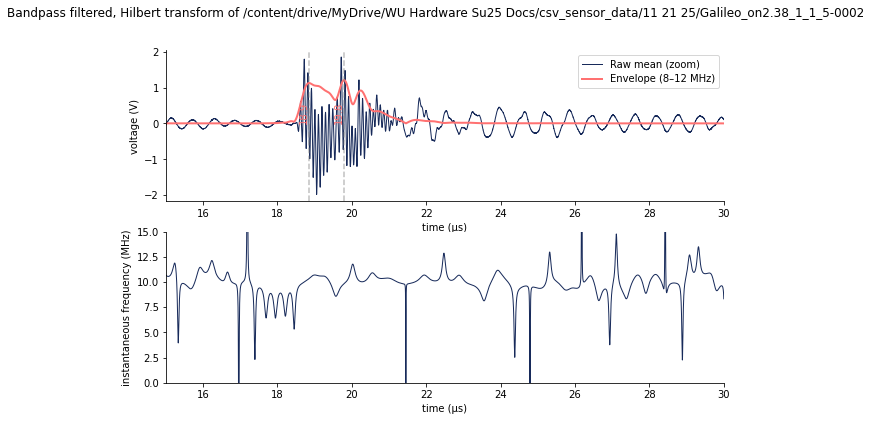


Peak locations for /content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002:


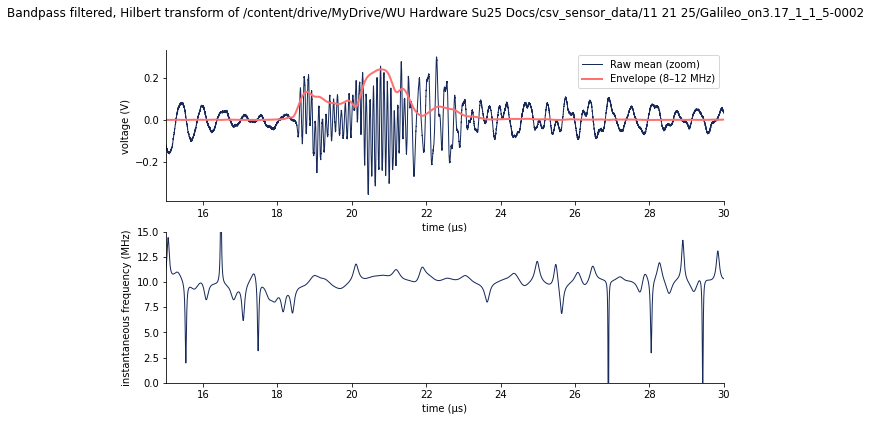

In [ ]:
   def channel_b_bandpass_hilbert(t, B, filename):
    """
    t : time in microseconds (µs), shape (N,)
    A : RF data, shape (N, M) or (N,)
    filename : used for figure title and saving
    """
    ta, tb = 15, 30
    twin = (t > ta) & (t <= tb)

    # --- mean trace ---
    Amean = B.mean(1) if B.ndim > 1 else B

    # --- fixed band-pass: 8–12 MHz Butterworth, zero-phase ---
    dt_us = np.median(np.diff(t))        # µs
    fs = 1.0 / (dt_us * 1e-6)            # Hz
    nyq = 0.5 * fs
    Wn = [8e6/nyq, 12e6/nyq]             # 8–12 MHz
    b, a = ss.butter(4, Wn, btype='band')
    Afilt = ss.filtfilt(b, a, Amean)

    # --- analytic signal, envelope, phase, inst. freq (MHz) ---
    Bh = ss.hilbert(Afilt)
    envelope = np.abs(Bh)

    # -- peaks ---
    peaks, properties = ss.find_peaks(envelope,
    height=0.4,          # Minimum voltage
    distance=625,         # Minimum separation
    prominence=0.05,     # How distinct the peak must be
    width=100            # Minimum peak width
    )
    peak_heights = properties['peak_heights']
    peak_widths = properties['widths']
    peak_times = t[peaks]

    # After finding peaks and calculating peak_times
    print(f"\nPeak locations for {filename}:")
    for i, (time, height) in enumerate(zip(peak_times, peak_heights), 1):
        if time > ta and time <= tb:
            print(f"Peak {i}: time = {time:.2f} µs, amplitude = {height:.3f} V")

    phi = np.unwrap(np.angle(Bh))
    window = ss.windows.hann(21)
    window /= window.sum()
    phi = ss.convolve(phi - phi.mean(), window, mode='same')

    dphidt = np.gradient(phi) / np.gradient(t)   # rad / µs
    inst_freq_MHz = dphidt / (2*np.pi)          # cycles/µs = MHz
   # --- plotting (simple) ---

    plt.figure(figsize=(10, 6))
    plt.suptitle(f'Bandpass filtered, Hilbert transform of {filename}')

    plt.subplot(2, 1, 1)
    plt.plot(t[twin], Amean[twin], lw=1, label='Raw mean (zoom)')
    plt.plot(t[twin], envelope[twin], lw=2, label='Envelope (8–12 MHz)')

    # For the peak labels, add color and make text larger:
    for peak_time in peak_times[(peak_times > ta) & (peak_times <= tb)]:
        plt.axvline(x=peak_time, color='gray', linestyle='--', alpha=0.5)
        plt.text(peak_time, 0, f'{peak_time:.1f}', rotation=90,
                verticalalignment='bottom', horizontalalignment='right',
                color='#FF7171',  # using your second colorblind-friendly color
                fontsize=10)      # increase font size

    plt.xlim(ta, tb)
    plt.ylabel('voltage (V)')
    plt.xlabel('time (µs)')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(t[twin], inst_freq_MHz[twin], lw=1)
    plt.xlim(ta, tb)
    plt.ylim(0, 15)
    plt.xlabel('time (µs)')
    plt.ylabel('instantaneous frequency (MHz)')

    figures_dir = "filtered_img"
    # plt.savefig(f"{figures_dir}/bandpass_Hilbert_{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

#use case:
t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')
channel_b_bandpass_hilbert(t, B, '/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')

t, B, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002')
channel_b_bandpass_hilbert(t, B, '/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on3.17_1_1_5-0002')


FileNotFoundError: [Errno 2] No such file or directory: 'difference_img/difference_/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002.png'

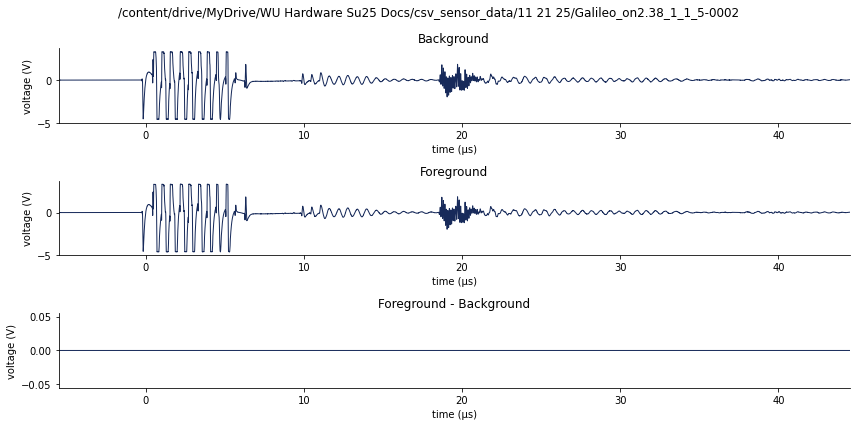

In [ ]:
# Plot foreground and background channel B data, and their difference

def channel_b_plot_fg_bg(t, Bfg, Bbg, filename):
  plt.figure(figsize=(12,6))
  plt.suptitle(filename)

  plt.subplot(3,1,1)
  plt.plot(t, Bbg.mean(1), c=cp[0], lw=1)
  plt.xlim(t[0], t[-1])
  plt.xlabel('time (µs)')
  plt.ylabel('voltage (V)')
  plt.title('Background')

  plt.subplot(3,1,2)
  plt.plot(t, Bfg.mean(1), c=cp[0], lw=1)
  plt.xlim(t[0], t[-1])
  plt.xlabel('time (µs)')
  plt.ylabel('voltage (V)')
  plt.title('Foreground')

  plt.subplot(3,1,3)
  plt.plot(t, Bfg.mean(1) - Bbg.mean(1), c=cp[0], lw=1)
  plt.xlim(t[0], t[-1])
  plt.xlabel('time (µs)')
  plt.ylabel('voltage (V)')
  plt.title('Foreground - Background')
  plt.tight_layout()
  figures_dir = Path("difference_img")
  figures_dir.mkdir(exist_ok=True)
  plt.savefig(figures_dir / f"difference_{filename}.png", dpi=300, bbox_inches="tight")
  plt.show()

#use case:
t, Bfg, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')
t, Bbg, unit_map = load_dir('/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002') #should have been wall
channel_b_plot_fg_bg(t, Bfg, Bbg, '/content/drive/MyDrive/WU Hardware Su25 Docs/csv_sensor_data/11 21 25/Galileo_on2.38_1_1_5-0002')

